# Chapter 08 - Exercises

### Exercise 8.1

**Q**

The nonplanning method looks particularly poor in Figure 8.3 because it is a one-step method; a method using multi-step bootstrapping would do better. Do you think one of the multi-step bootstrapping methods from Chapter 7 could do as well as the Dyna method? Explain why or why not.

**A**

A similar corresponding case is using a nonplanning method with multi-step bootstrapping with $n = 51$, because the planning simulates 50 cases after the direct RL update, and would update the last 51 state-action values after each step (in the first episode, only the last 51 states visited before the end of the episode will be updated, because only the final reward is non-zero). 

In the second episode, while the planning method starts with only the last non terminal state updated, after each step it can update a previously visited states considering the actions taken, and while in the beginning it has little chance of choosing a useful state-action pair that takes to a next state that was already updated, as the steps go on it updates more and more cases, going fast toward states closest to the beginning.

In the same second episode, for the non-planing 51-step TD, updating the values using the Q-learning method (that uses the best state-action value after in the last step, or 0 for the terminal state), all the initial steps wouldn't be able to update any state-action values. Only after the agent reaches an already updated state, it would update the states of the last steps, so it might be faster than the first case, TD(0), but it would probably take longer than the planning method because it can only update the last 51 steps, while the planning method may even update a state that was not reached yet in the episode. 

Furthermore, because the value of n for the n-step method is high, the possibility of a high variance is higher (although, because this environment has all rewards 0 except the last, the variance may ending up not being so high). One thing that might cause a high variance is a state s1 close to the end, but the agent took a bad direction and went to a lot of states farther from the final state, and then went to the final state without passing from the indicated state s1, making it have a worse value than it should have (this is more difficult to happen in the planning case, that uses TD(0), because it only consider neighbor states, reducing considerably the chances like the above scenario to happen, even if it's actually possible to happen too).

So, using a 51-step TD with Q-learning (using the maximum state-action value in the last step) may converge faster than TD(0) (or not, due to the variance), and can update a number of states just like the planning method with 50 simulations per step, but because the updates need to follow the last 50 steps, and can not be benefited from updates from previous episodes if it has not reached a state already updated in a previous episode, it probably will need more episodes than the planning method (using less steps for the nonplanning method may actually help to converge faster, although it probably won't have the same performance as the planning method). This answer is just a speculation tough. A real experiment may give a more concrete explanation.

### Exercise 8.2 

**Q**

Why did the Dyna agent with exploration bonus, Dyna-Q+, perform better in the first phase as well as in the second phase of the blocking and shortcut experiments?

**A**

It was better in the second phase due to the reasons already stated  in the example: it explores more than the Dyna agent, so when the environment changed, it found the change faster (in the shortcut experiment, Dyna haven't found the shortcut even in the next 3000 time-steps, while Dyna-Q+ found it after about 1000 time-steps).

For the first phase, the reason is less obvious, but it has to do with the fact that Dyna-Q+ gives priority to action-states not tried before. Considering that both used $\epsilon$-greedy policies, which means that there's already a possibility of exploration at each time-step, Dyna-Q+ gives priority to unknown states, making it explore and find the terminal state faster (Dyna may end up repeating the same states several times before finding the path to the terminal state, at least in the first episode).

### Exercise 8.3 

**Q**

Careful inspection of Figure 8.5 reveals that the difference between Dyna-Q+ and Dyna-Q narrowed slightly over the first part of the experiment. What is the reason for this?

**A**

The Dyna-Q+ method explores more and consequently is able to find the best path faster, but that has a cost, and that cost is that it continues exploring even if the best path was already found. Both methods explore due to the soft policy used, but in the Dyna case that exploration should be minimal. This means that after the optimal path is found, if no changes happen to the environment, the Dyna method may end up being a bit better than Dyna-Q+ over time (more reward per time-step, on average).

### Exercise 8.4 (programming) 

**Q**

The exploration bonus described above actually changes the estimated values of states and actions. Is this necessary? Suppose the bonus $\kappa \sqrt{\tau}$ was used not in updates, but solely in action selection. That is, suppose the action selected was always that for which $Q(S_t, a) + \kappa \sqrt{\tau(S_t, a)}$ was maximal. Carry out a gridworld experiment that tests and illustrates the strengths and weaknesses of this alternate approach.

**A**

In [18]:
class BaseEnv:
    def __init__(self, n_states: int, n_actions: int):
        self.n_states = n_states
        self.n_actions = n_actions

    def step(self, action: int) -> tuple[int, float, bool, bool]:
        raise NotImplementedError

    def reset(self, seed: int = 0) -> int:
        self.steps = 0

class BaseAgent:
    def __init__(self, env: BaseEnv):
        self.env = env

    def act(self, state: int) -> int:
        raise NotImplementedError

    def train(self, steps: int):
        raise NotImplementedError

    def reset(self):
        return

from numpy.random import MT19937, Generator

def random_generator(seed: int | None = None):
    bg = MT19937(seed)
    rg = Generator(bg)
    return rg

In [19]:
import matplotlib.pyplot as plt
import numpy as np

NORMAL_COLOR = np.array([1., 1., 1.])
START_COLOR = np.array([255, 99, 71]) / 255
FINISH_COLOR = np.array([152, 249, 152]) / 255
BARRIER_COLOR = np.array([0.5, 0.5, 0.5])
AGENT_COLOR = np.array([39, 116, 218]) / 255

TYPE_NORMAL = 0
TYPE_START = 1
TYPE_FINISH = 2
TYPE_BARRIER = 3

class GridWorldEnv(BaseEnv):
    def __init__(
        self,
        size: tuple[int, int],
        start: tuple[int, int],
        finish: tuple[int, int],
        barriers_over_time: list[tuple[int, list[tuple[int, int]]]],
        max_steps: int | None = None,
    ):
        rows, cols = size
        start_x, start_y = start
        s_start = start_y * cols + start_x
        finish_x, finish_y = finish
        s_finish = finish_y * cols + finish_x

        assert rows > 2 and cols > 2, "Invalid grid size"
        assert (start_y >= 0 and start_y < rows), f"Invalid start row: {start_y} (row should be in [0, {rows}))"
        assert (start_x >= 0 and start_x < cols), f"Invalid start column: {start_x} (column should be in [0, {cols}))"
        assert (finish_y >= 0 and finish_y < rows), f"Invalid finish row: {finish_y} (row should be in [0, {rows}))"
        assert (finish_x >= 0 and finish_x < cols), f"Invalid finish column: {finish_x} (column should be in [0, {cols}))"

        for time_step, barriers in barriers_over_time:
            for barrier in barriers:
                x, y = barrier
                assert (y >= 0 and y < rows), f"Invalid barrier row at time-step {time_step}: {y} (row should be in [0, {rows}))"
                assert (x >= 0 and x < cols), f"Invalid barrier column at time-step {time_step}: {x} (column should be in [0, {cols}))"
                assert barrier != start, f"Invalid barrier at time-step {time_step}: should not be in the start cell"
                assert barrier != finish, f"Invalid barrier at time-step {time_step}: should not be in the finish cell"

        grid = np.full((rows, cols), TYPE_NORMAL)
        grid[start_y, start_x] = TYPE_START
        grid[finish_y, finish_x] = TYPE_FINISH

        actions = [
            (0, 1),
            (1, 0),
            (0, -1),
            (-1, 0),
        ]

        n_states = rows * cols
        n_actions = len(actions)

        super().__init__(
            n_states=n_states,
            n_actions=n_actions)

        self.rows = rows
        self.cols = cols
        self.start = start
        self.s_start = s_start
        self.finish = finish
        self.s_finish = s_finish
        self.actions = actions
        self.grid = grid
        self.max_steps = max_steps
        self.barriers_over_time = barriers_over_time
        self.barrier_time_step = -1
        self.barriers: list[tuple[int, int]] = []

        self.steps = 0
        self.all_steps = 0
        self.state: int | None = None

        self.update_barriers()

    def update_barriers(self):
        rows = self.rows
        cols = self.cols
        all_steps = self.all_steps
        barriers_over_time = self.barriers_over_time
        grid = self.grid

        time_step = 0
        barriers: list[tuple[int, int]] = []

        for t, b in barriers_over_time:
            if t > all_steps:
                break

            time_step = t
            barriers = b

        if time_step > self.barrier_time_step:
            self.barrier_time_step = time_step
            self.barriers = barriers

            for row in range(rows):
                for col in range(cols):
                    if grid[row, col] == TYPE_BARRIER:
                        grid[row, col] = TYPE_NORMAL

            for x, y in barriers:
                grid[y, x] = TYPE_BARRIER

    def reset(self, seed: int = 0) -> int:
        state = self.s_start
        self.steps = 0
        self.state = state
        return state

    def reset_all_steps(self) -> int:
        state = self.reset()
        self.all_steps = 0
        self.barrier_time_step = -1
        self.update_barriers()
        return state

    def invalid_position(self, row: int, col: int) -> bool:
        return row < 0 or row >= self.rows or col < 0 or col >= self.cols or self.grid[row, col] == TYPE_BARRIER

    def step(self, action: int) -> tuple[int, float, bool, bool]:
        steps = self.steps + 1
        state = self.state

        assert state is not None, "The environment was not initialized"
        assert state != self.s_finish, "The environment is in a terminal state"

        row = state // self.cols
        col = state % self.cols

        action_move = self.actions[action]
        move_h, move_v = action_move

        new_row = row + move_v
        new_col = col + move_h
        new_state = state
        reward = 0
        terminated = False

        if not self.invalid_position(row=new_row, col=new_col):
            new_state = new_row * self.cols + new_col
            terminated = (new_state == self.s_finish)

            if terminated:
                reward = 1

        truncated = (not terminated) and (self.max_steps is not None) and (self.max_steps <= steps)

        self.steps = steps
        self.state = new_state
        self.all_steps += 1

        self.update_barriers()

        return new_state, reward, terminated, truncated

    def plot(self, title: str | None = None, history: list[int] = []):
        rows, cols = self.rows, self.cols

        color_grid = np.full((rows, cols, 3), NORMAL_COLOR)

        for row in range(rows):
            inv_row = rows - row - 1
            for col in range(cols):
                if self.grid[row, col] == TYPE_START:
                    color_grid[inv_row, col] = START_COLOR
                elif self.grid[row, col] == TYPE_FINISH:
                    color_grid[inv_row, col] = FINISH_COLOR
                elif self.grid[row, col] == TYPE_BARRIER:
                    color_grid[inv_row, col] = BARRIER_COLOR

        plt.figure(figsize=(12, 8))
        plt.imshow(color_grid, aspect='auto')
        plt.grid(which='both', color='#333', linestyle='-', linewidth=1)
        plt.xticks(np.arange(.5, self.cols, 1), [])
        plt.yticks(np.arange(.5, self.rows, 1), [])
        plt.tick_params(bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)

        for i, state in enumerate(history):
            row = state // self.cols
            col = state % self.cols
            row = rows - row - 1
            # color starts black and ends as AGENT_COLOR
            shade = i/len(history)
            color = np.array(AGENT_COLOR) * shade
            plt.plot(col, row, 'o', color=color, markersize=20)

        if title:
            plt.title(title)

        plt.show()

    @classmethod
    def blocking_maze(cls, max_steps: int | None = None):
        rows, cols = 6, 9
        start = (8, 5)
        finish = (3, 0)
        barriers_over_time = [
            (0, [(x, 2) for x in range(8)]),
            (1000, [(x, 2) for x in range(1, 9)]),
        ]
        return cls(
            size=(rows, cols),
            start=start,
            finish=finish,
            barriers_over_time=barriers_over_time,
            max_steps=max_steps)

    @classmethod
    def shortcut_maze(cls, max_steps: int | None = None):
        rows, cols = 6, 9
        start = (8, 5)
        finish = (3, 0)
        barriers_over_time = [
            (0, [(x, 2) for x in range(1, 9)]),
            (3000, [(x, 2) for x in range(1, 8)]),
        ]
        return cls(
            size=(rows, cols),
            start=start,
            finish=finish,
            barriers_over_time=barriers_over_time,
            max_steps=max_steps)

class GridWorldAgentParams:
    def __init__(
        self,
        state: int,
        action: int,
        reward: float,
        next_state: int,
        terminated: bool,
        truncated: bool,
    ):
        self.state = state
        self.action = action
        self.reward = reward
        self.next_state = next_state
        self.terminated = terminated
        self.truncated = truncated


class GridWorldAgent(BaseAgent):
    def __init__(self, env: GridWorldEnv, name: str):
        super().__init__(env)
        self.grid_env = env
        self.name = name

    def train(self, steps: int):
        self.train_with_rewards(steps=steps, plot=False)

    def update(self, params: GridWorldAgentParams) -> None:
        raise NotImplementedError

    def train_with_rewards(self, steps: int, plot=True, no_history=False) -> list[float]:
        state = self.grid_env.reset_all_steps()
        all_steps = 0
        rewards = 0
        terminated = False
        truncated = False
        history = [state]
        last_full_history: tuple[list[int], bool, bool] | None = None
        reward_history: list[float] = [0]

        while all_steps < steps:
            all_steps += 1
            action = self.act(state)
            next_state, r, c, t = self.env.step(action)
            rewards += r
            terminated = c
            truncated = t

            self.update(GridWorldAgentParams(
                state=state,
                action=action,
                reward=r,
                next_state=next_state,
                terminated=terminated,
                truncated=truncated,
            ))

            if not no_history:
                history.append(next_state)
            reward_history.append(rewards)

            if terminated or truncated:
                state = self.env.reset()
                last_full_history = (history, terminated, truncated)
                history = [state]
            else:
                state = next_state

        if not last_full_history:
            last_full_history = [history, terminated, truncated]

        history, _, _ = last_full_history

        if plot:
            self.grid_env.plot(title=self.name, history=[] if no_history else history)

        return reward_history

class TestAgent(GridWorldAgent):
    def __init__(self, env: GridWorldEnv, name: str):
        super().__init__(env=env, name=name)

    def act(self, state: int) -> int:
        return 0 # Always North

    def update(self, params: GridWorldAgentParams) -> None:
        return

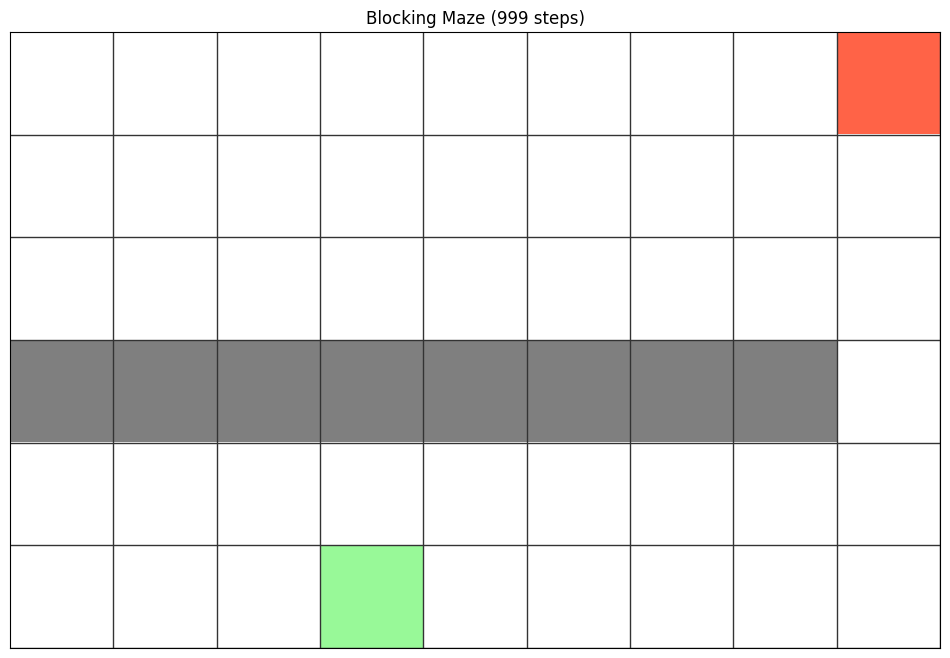

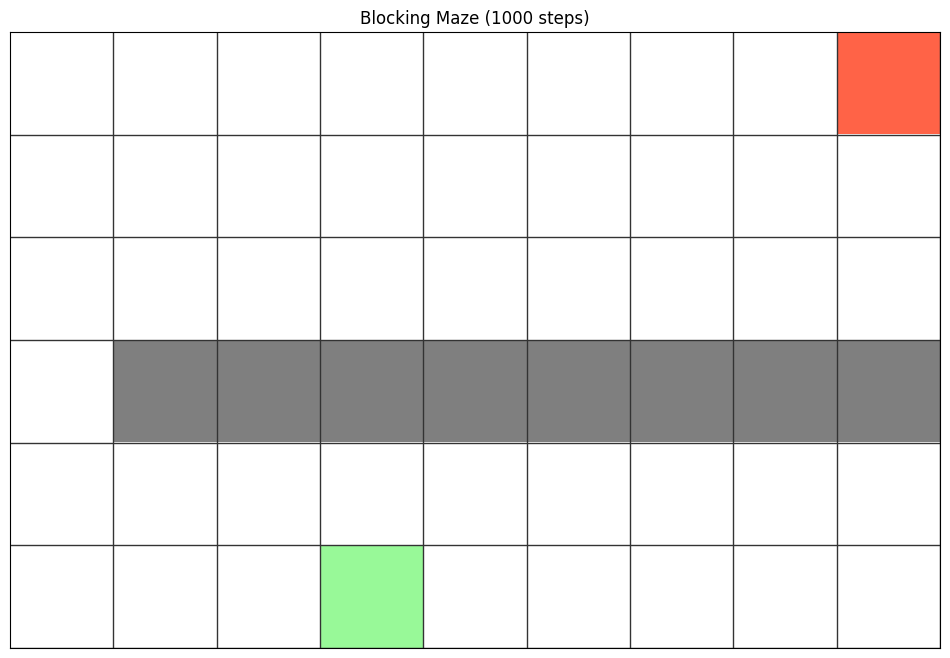

In [20]:
env = GridWorldEnv.blocking_maze(max_steps=300)
agent = TestAgent(env, name='Blocking Maze (999 steps)')
agent.train_with_rewards(steps=999, no_history=True)
state = env.reset()
action = agent.act(state)
env.step(action)
env.plot(title='Blocking Maze (1000 steps)')

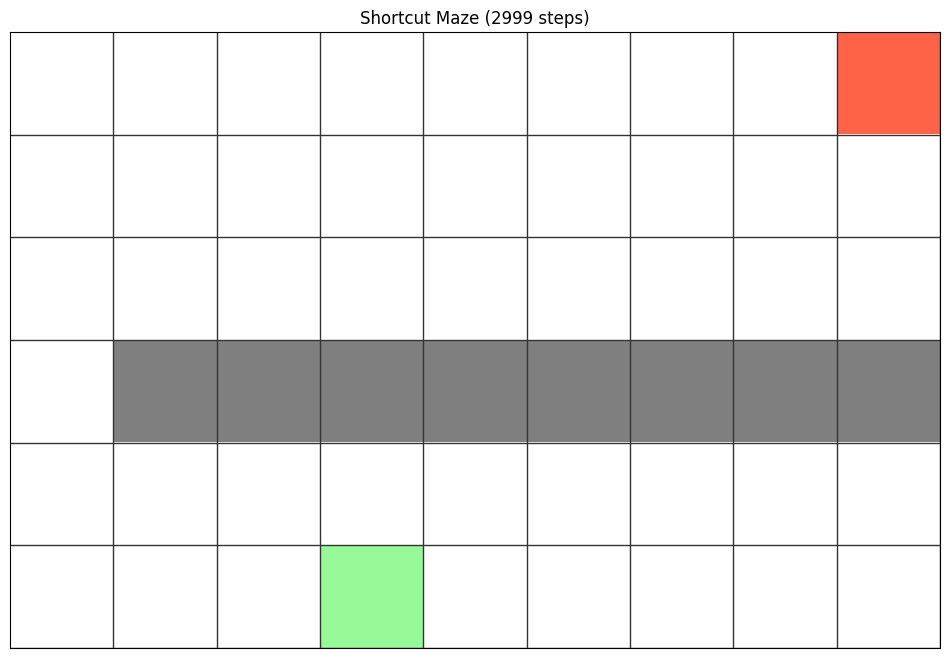

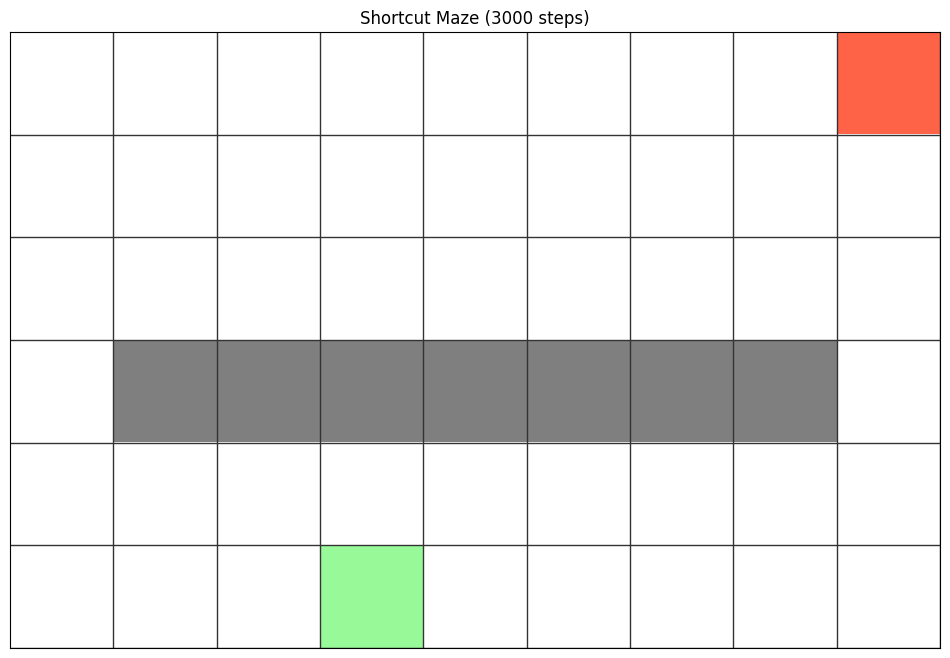

In [21]:
env = GridWorldEnv.shortcut_maze(max_steps=300)
agent = TestAgent(env, name='Shortcut Maze (2999 steps)')
agent.train_with_rewards(steps=2999, no_history=True)
state = env.reset()
action = agent.act(state)
env.step(action)
env.plot(title='Shortcut Maze (3000 steps)')

In [22]:
class DynaAgent(GridWorldAgent):
    def __init__(
        self,
        env: GridWorldEnv,
        name: str,
        n_plan: int = 0,
        alpha: float = 0.2,
        gamma: float = 0.9,
        epsilon: float = 0.1,
        kappa: float = 0,
        seed: int | None = None,
    ):
        super().__init__(env=env, name=name)
        self.n_plan = n_plan
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.kappa = kappa
        self.Q = np.ones((env.n_states, env.n_actions), dtype=float)
        self.Q[env.s_finish, :] = 0
        self.M: dict[tuple[int, int], tuple[int, int]] = dict()
        self.actions = 0
        self.T: dict[tuple[int, int], int] = dict()
        self.rg = random_generator(seed)

    def train_with_rewards(self, steps: int, plot=True, no_history=False) -> list[float]:
        self.actions = 0
        self.tau = dict()
        result = super().train_with_rewards(steps=steps, plot=plot, no_history=no_history)
        return result

    def act(self, state: int) -> int:
        n_actions = self.env.n_actions
        epsilon = self.epsilon
        kappa = self.kappa
        qs = self.Q[state]

        if kappa > 0:
            action = next((a for a in range(n_actions) if (state, a) not in self.T), None)

            if action is None:
                taus = [self.actions - self.T[(state, a)] for a in range(n_actions)]
                qs = [q + kappa * (tau**(1/2)) for q, tau in zip(qs, taus)]
                action: int = np.argmax(qs)

            self.T[(state, action)] = self.actions
            self.actions += 1
            return action
        else:
            probs = np.ones(n_actions, dtype=float) * epsilon / n_actions
            probs[np.argmax(qs)] += 1 - epsilon
            action = self.rg.choice(len(probs), p=probs)
            return action

    def sample(self) -> tuple[int, int]:
        M = self.M
        keys = list(M.keys())
        idx = self.rg.choice(len(keys))
        state, action = keys[idx]
        return state, action

    def update(self, params: GridWorldAgentParams) -> None:
        state = params.state
        action = params.action
        reward = params.reward
        next_state = params.next_state

        Q = self.Q
        n_plan = self.n_plan
        alpha = self.alpha
        gamma = self.gamma

        Q[state, action] += alpha * (reward + gamma * max(Q[next_state]) - Q[state, action])
        self.M[(state, action)] = (reward, next_state)

        for _ in range(n_plan):
            s, a = self.sample()
            r, sp = self.M[(s, a)]
            Q[s, a] += alpha * (r + gamma * max(Q[sp]) - Q[s, a])

In [23]:
def plot_gridworld(title: str, agents: list[DynaAgent], steps: int):
    rewards: list[tuple[str, list[float]]] = []

    for agent in agents:
        r = agent.train_with_rewards(steps=steps, plot=False, no_history=True)
        rewards.append((agent.name, r))

    plt.figure(figsize=(8, 8))

    for name, r in rewards:
        plt.plot(r, label=name)

    plt.xlabel('Time steps')
    plt.ylabel('Cumulative reward')
    plt.title(title)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [24]:
def test_gridworld(name: str, env: GridWorldEnv, steps: int, seed: int | None = 1):
    agents: list[DynaAgent] = [
        DynaAgent(
            env,
            name='No Exploration Bonus - n=10 - epsilon=10%',
            n_plan=10,
            kappa=0,
            epsilon=0.1,
            seed=seed,
        ),
        DynaAgent(
            env,
            name='No Exploration Bonus - n=50 - epsilon=10%',
            n_plan=50,
            kappa=0,
            epsilon=0.1,
            seed=seed,
        ),
        DynaAgent(
            env,
            name='No Exploration Bonus - n=10 - epsilon=1%',
            n_plan=10,
            kappa=0,
            epsilon=0.01,
            seed=seed,
        ),
        DynaAgent(
            env,
            name='No Exploration Bonus - n=50 - epsilon=1%',
            n_plan=50,
            kappa=0,
            epsilon=0.01,
            seed=seed,
        ),
        DynaAgent(
            env,
            name='Exploration 10% - n=10',
            n_plan=10,
            kappa=0.1,
            seed=seed,
        ),
        DynaAgent(
            env,
            name='Exploration 10% - n=50',
            n_plan=50,
            kappa=0.1,
            seed=seed,
        ),
        DynaAgent(
            env,
            name='Exploration 1% - n=10',
            n_plan=10,
            kappa=0.01,
            seed=seed,
        ),
        DynaAgent(
            env,
            name='Exploration 1% - n=50',
            n_plan=50,
            kappa=0.01,
            seed=seed,
        ),
        DynaAgent(
            env,
            name='Exploration 0.1% - n=10',
            n_plan=10,
            kappa=0.001,
            seed=seed,
        ),
        DynaAgent(
            env,
            name='Exploration 0.1% - n=50',
            n_plan=50,
            kappa=0.001,
            seed=seed,
        ),
    ]
    plot_gridworld(title=name, agents=agents, steps=steps)

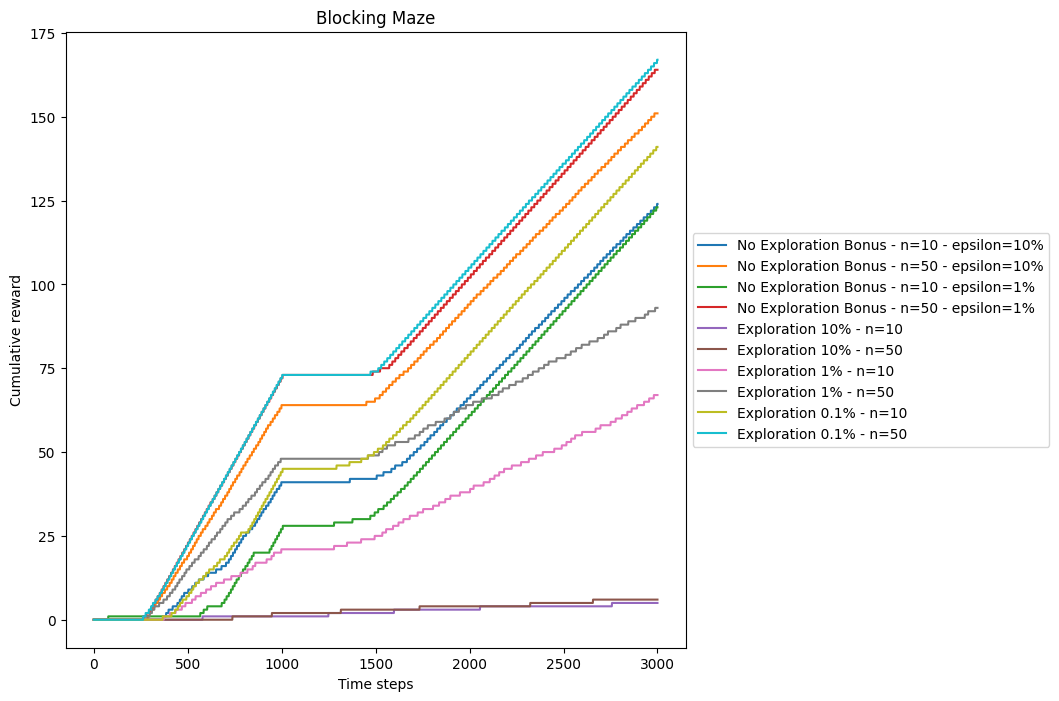

In [25]:
env = GridWorldEnv.blocking_maze(max_steps=300)
test_gridworld(name='Blocking Maze', env=env, steps=3000)

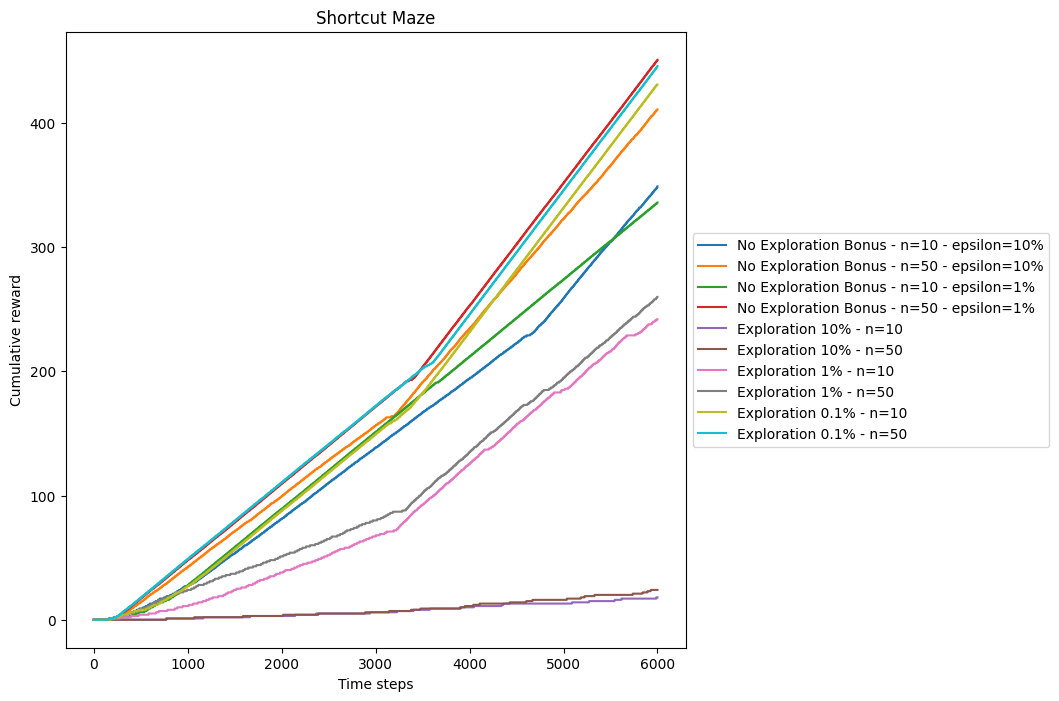

In [26]:
env = GridWorldEnv.shortcut_maze(max_steps=300)
test_gridworld(name='Shortcut Maze', env=env, steps=6000)

The tests were made for $n=10$ and $n=50$ (n is the number of simulations in the planning step) and for the cases of no exploration ($\kappa = 0$) and for $\kappa=0.1$, $\kappa=0.01$ and $\kappa=0.001$. For the cases of no exploration, it was used $\epsilon=0.1$ and $\epsilon=0.01$ for the $\epsilon$-greedy policy (the values of $\epsilon$ have no impact in the case with $\kappa > 0$, because it only considers the highest value; the exploration happen due to places that were not visited recently applying a bonus in the value). 

So, there're a total of 10 different cases for both the blocking maze and the shortcut maze.

Based on the results above, the worst cases in both mazes were for $\kappa=0.1$, followed by the cases of $\kappa=0.01$ (for both $n=10$ and $n=50$). This is because it explores too much, and takes too much time to reach the destination (this is specially evident in this deterministic environment that changes only once).

The best result is both mazes were for $(\kappa=0, n=50, \epsilon=0.01)$ and for $(\kappa=0.001, n=50)$. This is due to the small value of $\epsilon$ for the case without exploration bonus, and the small value of $\kappa$ for the case with exploration bonus. After the agent finds the best path, the less exploration to happen, the better. In the initial steps, and also after the environment changes, it's important to have some exploration. These cases found it relatively fast in the initial steps for the blocking maze, and after the environment changed in the shortcut maze, even with a small exploration, due to a high value of $n$ (a lot of simulations in the planning step).

Following that, the next best cases are for $(\kappa=0.001, n=10)$ and $(\kappa=0, n=50, \epsilon=0.1)$, The first due to the lower exploration, but still having the bonus exploration that helped it find the changes in the environment relatively fast in the shortcut maze, and to find the initial best path in the blocking maze, the later because it has a high value of $n$ and a good exploration rate due to the value of $\epsilon$, finding the best path faster due to the high number of simulations per step (this is especially evident when compared to the other identical case except for the value of n, $(\kappa=0, n=10, \epsilon=0.1)$, in the shortcut maze, that takes considerably more time to find the best path after the change in the enviroment).

To make the agents find the best path faster, the initial values of $Q$ were defined as 1, because they decrease the values of the places that are more distant from the terminal state, as more actions are done in those states, due to the discount factor ($\gamma$) and reward 0 for the actions.

### Exercise 8.5 

**Q**

How might the tabular Dyna-Q algorithm shown on page 164 be modified to handle stochastic environments? How might this modification perform poorly on changing environments such as considered in this section? How could the algorithm be modified to handle stochastic environments and changing environments?

**A**

In a stochastic environment, given a state and an action done in this state, instead of a fixed next state and reward, there's a distribution of probabilities for each possible next state and reward. To handle such an environment, each next state and reward can be given a weight, incremented by 1 every time that case happen, with the planning done based on this distribution: the model in this case returns the distribution probability, and the simulation is done picking one of the possibilities based on its probability.

This might perform poorly when the environment changes due to the weights from the previous environment, and lots of real experiments will be required to make the new (actually, updated) weights outweight the (now incorrect) previous weights. To handle both scenarios, before incrementing the weight of the next state and reward given a state and an action, it can multiply all the weights of the distribution of the given state and action by a discount factor smaller than 1 to reduce the overall impact of the previous cases, but higher than 0 to not discard them completely.

Of course, making the agent explore more, especially state-action pairs not used for a long time, can also be seen as a possible solution, in which case the Dyna-Q method would actually become Dyna-Q+.

### Exercise 8.6

**Q**

The analysis above assumed that all of the *b* possible next states were equally likely to occur. Suppose instead that the distribution was highly skewed, that some of the *b* states were much more likely to occur than most. Would this strengthen or weaken the case for sample updates over expected updates? Support your answer.

**A**

This would strengthen the case for sample updates over expected updates. The expected updates will continue updating over all possible actions, even for the *b* states that are very unlikely to occur, and consequently won't affect the final value too much. The sample updates, on the other hand, are chosen based on the actual transitions, so the *b* states that are much more likely to occur will be more present in those transitions, and that means that the value updates will be done using the cases that are more likely to happen, which are also the cases that have the most impact in the real value (higher values of $p(s', r | s, a)$, in which *b* affects the amount of possible next states, $s'$, given a state and an action, $s$ and $a$).

### Exercise 8.7

**Q**

Some of the graphs in Figure 8.8 seem to be scalloped in their early portions, particularly the upper graph for $b = 1$ and the uniform distribution. Why do you think this is? What aspects of the data shown support your hypothesis?

**A**

Some points to take into account:

1. There are exactly 2 possible actions at every state;
2. Each state-action pair have $b$ possible transitions to $b$ different states, each with an expected reward with mean 0 and variance 1;
3. The expected reward per transition is considered fixed (for example, 0.3), but the actual reward may vary (it's not stated that the rewards for each transition are fixed or may change, the example says only about the expected rewards).

It's important to consider that the *uniform* updates are distributed accross all visited state-action pairs, so the chances of choosing the start state or some neighbor states is much lower than in the on-policy case, because the chances of each transition terminate the episode is 10%, in which case the simulated on-policy case would start again at the start state (the chances are about 200 times higher than in the uniform case, when almost all 2000 state-action pairs are known).

Another point to consider is for the case in which the actual rewards from transition may give different values. The *uniform* case cycle through all state-action pairs, and updates them. The updates get the weight of the probability of the transition happening among the possible transitions of that state-action pair. It's expected that the transitions that are unlikely to be followed by the policy will happen less frequently, so it may end up having the value being much higher or lower than it should actually have, because the actual mean (expected) reward is not reflected in the model (this, considering that the transitions do not give a fixed reward).

The policy followed is $\epsilon$-greedy, so after the states of the wrong action-values, that have a higher value than they should have, start approaching (and being reflected in) the initial state after the planning updates, the policy may end up prioritise choosing them (after the agent starts the trajectory again), having more samples of the transitions of that state-action pair and updating the model and corresponding action-value faster until their values reduce and they end up being less prioritised by the policy. This should be what cause the graphs to be scalloped in the early portions (as the model is updated, the values should be updated with more correct weights, reducing the scalloping with time).

### Exercise 8.8 (programming)

**Q**

Replicate the experiment whose results are shown in the lower part of Figure 8.8, then try the same experiment but with $b = 3$. Discuss the meaning of your results.

**A**

In [27]:
class BaseEnv:
    def __init__(self, n_states: int, n_actions: int):
        self.n_states = n_states
        self.n_actions = n_actions
        self.state: int | None = None

    def step(self, action: int) -> tuple[int, float, bool, bool]:
        raise NotImplementedError

    def reset(self, seed: int = 0) -> int:
        self.steps = 0

class BaseAgent:
    def __init__(self, env: BaseEnv):
        self.env = env

    def act(self, state: int) -> int:
        raise NotImplementedError

    def train(self, steps: int):
        raise NotImplementedError

    def reset(self):
        return

from numpy.random import MT19937, Generator

def random_generator(seed: int | None = None):
    bg = MT19937(seed)
    rg = Generator(bg)
    return rg

In [28]:
import numpy as np

class BranchingEnv(BaseEnv):
    def __init__(self, n_states: int, b=1, mean=0, deviation=1, seed: int | None = None, verbose: bool = False):
        assert n_states >= b + 1, f"The number of different states ({n_states}) must be more than b + 1 ({b + 1})"
        assert b >= 1, f"The branching ({b}) must be 1 or higher"

        actions = [0, 1]
        n_actions = len(actions)
        rg = random_generator(seed)

        super().__init__(
            n_states=n_states,
            n_actions=n_actions)

        self.b = b
        self.steps = 0
        self.state: int | None = None
        self.rg = rg
        self.mean = mean
        self.deviation = deviation
        self.verbose = verbose

        self.transitions = self.create_transitions()

    def create_transitions(self):
        return [
            [
                [
                    (
                        # random move to any spot that is not the same state,
                        # and also not the terminal state (self.n_states-1)
                        (s + self.rg.choice(range(1, self.n_states-1))) % (self.n_states-1),
                        self.rg.normal(loc=self.mean, scale=self.deviation),
                    )
                    for _ in range(self.b)
                ]
                for _ in range(self.n_actions)
            ]
            for s in range(self.n_states)
        ]

    def reset(self, seed: int | None = None) -> int:
        state = 0
        rg = random_generator(seed)
        self.steps = 0
        self.state = state
        self.rg = rg
        return state

    def step(self, action: int) -> tuple[int, float, bool, bool]:
        steps = self.steps + 1
        state = self.state

        assert state is not None, "The environment was not initialized"
        assert state != (self.n_states - 1), "The environment is in a terminal state"

        b_chosen = self.rg.choice(range(self.b))
        next_state, reward = self.transitions[state][action][b_chosen]
        terminated = self.rg.random() < 0.1 or (next_state == (self.n_states - 1))
        next_state = (self.n_states - 1) if terminated else next_state
        reward = 0 if terminated else reward
        truncated = False

        self.steps = steps
        self.state = next_state

        if self.verbose:
            prefix = f'{state} ' if steps == 1 else ''
            print(f'{prefix}-> {next_state} ({reward:.2f})', end=' ' if not terminated else '\n')

        return next_state, reward, terminated, truncated

In [29]:
from collections import defaultdict

class EnhancedBaseAgentParams:
    def __init__(
        self,
        state: int,
        action: int,
        reward: float,
        next_state: int,
        next_action: int,
        terminated: bool,
        truncated: bool,
    ):
        self.state = state
        self.action = action
        self.next_state = next_state
        self.next_action = next_action
        self.reward = reward
        self.terminated = terminated
        self.truncated = truncated

class EnhancedBaseAgent(BaseAgent):
    def __init__(
        self,
        env: BaseEnv,
        n_plan: int | None = None, # None when the planning is over the trajectory or all known state-action pairs
        plan_all: bool = False, # n_plan must be None; True for planning over the trajectory, False for all known state-action pairs
        alpha: float | None = None, # None for expected updates
        gamma: float = 1, # 1 for undiscounted task
        epsilon: float = 0.1, # exploration rate (epsilon-greedy policy)
        q_learning: bool = True, # True to update based on the maximum value of Q
        max_updates: int | None = None,
        seed: int | None = None,
    ):
        super().__init__(env=env)
        self.n_plan = n_plan
        self.plan_all = plan_all
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_learning = q_learning
        self.Q = np.zeros((env.n_states, env.n_actions), dtype=float)
        self.TA: dict[tuple[int, int], int] = defaultdict(int) # amount of transitions from (S, A)
        self.SP: dict[tuple[int, int], dict[int, int]] = defaultdict(lambda: defaultdict(int)) # amount of times in which (S, A) -> S'
        self.T: dict[tuple[int, int, int], int] = defaultdict(int) # amount of times in which (S, A) -> S', flattened with key (S, A, S')
        self.M: dict[tuple[int, int], dict[int, float]] = defaultdict(dict) # probability of (S, A) -> S'
        self.R: dict[tuple[int, int, int], float] = defaultdict(float) # mean reward of (S, A, S') (based on the amount defined in SP)
        self.max_updates = max_updates
        self.seed = seed
        self.rg = random_generator(seed)
        self.updates = 0

    def reset(self):
        self.updates = 0

    def initial_state(self) -> int:
        raise NotImplementedError

    def is_terminal(self, state: int) -> bool:
        raise NotImplementedError

    def act(self, state: int) -> int:
        n_actions = self.env.n_actions
        epsilon = self.epsilon
        qs = self.Q[state]
        probs = np.ones(n_actions, dtype=float) * epsilon / n_actions
        probs[np.argmax(qs)] += 1 - epsilon
        action = self.rg.choice(len(probs), p=probs)
        return action

    def act_plan(self, state: int) -> int | None:
        n_actions = self.env.n_actions
        epsilon = self.epsilon
        allowed_actions = [a for a in range(n_actions) if self.TA[(state, a)]]

        if state != self.env.state:
            # every state accessed during planning must have already transitioned
            # to another state, except the current state in the real run, that may
            # not have made any transition yet
            assert len(allowed_actions) > 0

        if not allowed_actions:
            return None

        qs = [self.Q[state, a] for a in allowed_actions]
        n_actions = len(qs)
        probs = np.ones(n_actions, dtype=float) * epsilon / n_actions
        probs[np.argmax(qs)] += 1 - epsilon
        action = self.rg.choice(allowed_actions, p=probs)
        return action

    def sample_cause(self) -> tuple[int, int]:
        keys = [key for key in self.TA if self.TA[key]]
        idx = self.rg.choice(len(keys))
        state, action = keys[idx]
        return state, action

    def sample_effect(self, state_action: tuple[int, int]) -> tuple[int, float] | None:
        probs_dict = self.M[state_action]
        probs_states = [s for s in probs_dict]
        probs = [probs_dict[s] for s in probs_dict]
        next_state = self.rg.choice(probs_states, p=probs)
        state, action = state_action
        expected_r = self.R[(state, action, next_state)]
        return next_state, expected_r

    def next_value(self, params: EnhancedBaseAgentParams, q_learning: bool) -> float:
        next_state = params.next_state
        next_action = params.next_action
        terminated = params.terminated
        Q = self.Q

        if terminated:
            return 0

        if q_learning:
            return max(Q[next_state])

        assert next_action is not None

        return Q[next_state, next_action]

    def single_update_value(self) -> None:
        self.updates += 1

    # called after a real action
    def update(self, params: EnhancedBaseAgentParams) -> None:
        self.update_model(params)
        self.update_value(params)
        self.plan()

    # called after a real action
    def update_model(self, params: EnhancedBaseAgentParams):
        state = params.state
        action = params.action
        next_state = params.next_state
        reward = params.reward
        state_action = (state, action)
        san = (state, action, next_state)
        self.TA[state_action] += 1
        self.T[san] += 1
        self.R[san] = ((self.T[san] - 1) * self.R[san] + reward) / self.T[san]
        self.SP[state_action][next_state] += 1
        for sp in self.SP[state_action]:
            self.M[state_action][sp] = self.T[(state, action, sp)] / self.TA[state_action]

    # called both in real actions and simulated actions
    def update_value(self, params: EnhancedBaseAgentParams) -> float:
        state = params.state
        action = params.action
        reward = params.reward

        Q = self.Q
        alpha = self.alpha
        gamma = self.gamma

        if alpha is not None:
            next_value = self.next_value(params=params, q_learning=self.q_learning)
            Q[state, action] += alpha * (reward + gamma * next_value - Q[state, action])
        else:
            # Expected Updates
            probs = self.M[(state, action)]
            Q[state, action] = 0
            for sp in probs:
                reward = self.R[(state, action, sp)]
                terminated = self.is_terminal(sp)
                next_value = self.next_value(
                    params=EnhancedBaseAgentParams(
                        state=state,
                        action=action,
                        reward=reward,
                        next_state=sp,
                        next_action=None,
                        terminated=terminated,
                        truncated=False,
                    ),
                    q_learning=True,
                )
                Q[state, action] += probs[sp] * (reward + gamma * next_value - Q[state, action])

        self.single_update_value()

    def plan(self):
        # True for planning over all known state-action pairs for every step,
        # otherwise it uses the on-police trajectory
        plan_all = self.plan_all
        n_plan = self.n_plan
        idx_plan_all = 0
        ta_keys = [key for key in self.TA if self.TA[key] > 0]
        terminated = False
        count = 0

        if plan_all:
            s, a = ta_keys[idx_plan_all]
        else:
            s = self.initial_state()
            a = self.act_plan(s)

        # store the states already planned when plan_all is False, to avoid infinite loops
        planned_states = set([s])

        while True:
            if self.max_updates is not None:
                if self.updates >= self.max_updates:
                    break
            sp, r = self.sample_effect((s, a))
            terminated = self.is_terminal(sp)
            ap = None if terminated else self.act_plan(sp)
            truncated = (ap is None) and not terminated

            self.update_value(EnhancedBaseAgentParams(
                state=s,
                action=a,
                reward=r,
                next_state=sp,
                next_action=ap,
                terminated=terminated,
                truncated=truncated,
            ))

            if n_plan is not None:
                count += 1
                if count >= n_plan:
                    break

            if plan_all:
                # iterate over all pairs (state, action)
                idx_plan_all += 1
                if idx_plan_all >= len(ta_keys):
                    if n_plan is not None:
                        idx_plan_all = 0
                    else:
                        break
                s, a = ta_keys[idx_plan_all]
            elif terminated or truncated:
                if n_plan is not None:
                    # only if episode anded and have an explicit number of simulations per step
                    s = self.initial_state()
                    a = self.act_plan(s)
                    planned_states.clear()
                else:
                    break
            elif sp not in planned_states:
                # continue trajectory, avoiding cycles
                planned_states.add(sp)
                s = sp
                a = ap
            elif n_plan is not None:
                # only if have an explicit number of simulations per step
                s = self.initial_state()
                a = self.act_plan(s)
                planned_states.clear()
            else:
                break

In [30]:
class BranchingDynaAgent(EnhancedBaseAgent):
    def __init__(
        self,
        env: BranchingEnv,
        plan_all: bool = False,
        alpha: float | None = None, # None for expected updates
        gamma: float = 1, # 1 for undiscounted task
        epsilon: float = 0.1,
        q_learning: bool = True, # True to update based on the maximum value of Q
        max_updates: int | None = None,
        seed: int | None = None,
    ):
        super().__init__(
            env=env,
            alpha=alpha,
            gamma=gamma,
            epsilon=epsilon,
            q_learning=q_learning,
            max_updates=max_updates,
            seed=seed)
        self.plan_all = plan_all
        self.values_history: list[float] = []

    def reset(self) -> float:
        super().reset()
        self.values_history = [self.initial_value()]

    def initial_state(self) -> int:
        return 0

    def initial_value(self) -> float:
        n_actions = self.env.n_actions
        epsilon = self.epsilon
        qs = self.Q[self.initial_state()]
        probs = np.ones(n_actions, dtype=float) * epsilon / n_actions
        probs[np.argmax(qs)] += 1 - epsilon
        v_s0 = sum([p*q for p, q in zip(probs, qs)])
        return v_s0

    def is_terminal(self, state: int) -> bool:
        return state == self.env.n_states - 1

    def single_update_value(self) -> None:
        super().single_update_value()
        self.values_history.append(self.initial_value())

    def train(self, verbose=False) -> list[float]:
        self.reset()

        terminated = False
        truncated = False
        max_seed = self.env.n_states * 100
        # the reset seed is to make sure that a sequence of episodes
        # don't terminate (with 10% chance) after the exact same steps,
        # if the the same actions are performed over several episodes
        # (if the same seed was used for different resets, a sequency
        # of the same actions would produce the same results, because
        # the chosen branches would be the same, and the termination
        # would happen after the exact same steps, which could cause
        # some state-action values end up with extremely large values)
        reset_seed = self.rg.integers(0, max_seed)
        state = self.env.reset(reset_seed)
        action = self.act(state)
        episode = 0
        steps = 0
        rewards = 0

        while self.updates < self.max_updates:
            next_state, r, terminated, truncated = self.env.step(action)
            steps += 1
            rewards += r
            next_action = self.act(next_state)

            self.update(EnhancedBaseAgentParams(
                state=state,
                action=action,
                reward=r,
                next_state=next_state,
                next_action=next_action,
                terminated=terminated,
                truncated=truncated,
            ))

            if terminated or truncated:
                episode += 1
                if verbose:
                    print(f'[{episode}] [Q0={self.initial_value():.2f}] Steps: {steps} - Cumulative Reward: {rewards} - Updates: {self.updates}')
                steps = 0
                rewards = 0

                reset_seed = self.rg.integers(0, max_seed)
                state = self.env.reset(reset_seed)
                action = self.act(state)
            else:
                state = next_state
                action = next_action

        return self.values_history

In [31]:
def test_case(n_states: int, plan_all: bool, b: int, max_updates: int, seed: int | None, verbose: bool = False) -> list[float]:
    if verbose:
        print('seed', seed)
    env = BranchingEnv(n_states=n_states, b=b, seed=seed, verbose=verbose)
    agent = BranchingDynaAgent(env=env, plan_all=plan_all, max_updates=max_updates, seed=seed, gamma=1.0)
    values_history = agent.train(verbose=verbose)
    if verbose:
        print()
        print('-' * 80)
        print(agent.Q[:20])
        print('...')
        print(agent.Q[-20:])
    return values_history

In [32]:
import typing
import matplotlib.pyplot as plt

def show_branching(title: str, tasks: int, cases: list[tuple[str, typing.Callable[[int], list[float]]]], seed: int | None = None):
    print('=' * 80)
    print('Last value of start state')
    results: list[tuple[str, list[float]]] = []
    for i, (name, fn) in enumerate(cases):
        rg = random_generator(seed)
        if i > 0:
            print('-' * 80)
        avg_q: list[float] | None = None
        for task in range(tasks):
            task_seed = rg.integers(low=0, high=100*tasks)
            q_values = fn(task_seed)
            print(f'[task: {task+1}] {name}: {q_values[-1]}')
            avg_q = [
                (avg_q[i] if avg_q is not None else 0) + (q_values[i]/tasks)
                for i in range(len(q_values))
            ]
        assert avg_q is not None
        results.append((name, avg_q))
        print(f'[avg] {name}: {avg_q[-1]}')
    print('=' * 80)

    plt.figure(figsize=(8, 8))

    for name, q_values in results:
        plt.plot(q_values, label=name)

    plt.xlabel('Computation time, in expected updates')
    plt.ylabel('Value of start state under greedy policy')
    plt.title(title)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [33]:
seed = 7183
_ = test_case(n_states=1000, plan_all=False, b=1, max_updates=20000, seed=seed, verbose=True)

seed 7183
0 -> 430 (1.30) -> 562 (-0.72) -> 631 (0.46) -> 324 (1.20) -> 774 (-1.29) -> 999 (0.00)
[1] [Q0=2.13] Steps: 6 - Cumulative Reward: 0.9502257899948308 - Updates: 27
0 -> 430 (1.30) -> 562 (-0.72) -> 631 (0.46) -> 324 (1.20) -> 905 (0.64) -> 767 (1.13) -> 227 (1.01) -> 220 (1.14) -> 60 (-1.11) -> 931 (-1.82) -> 239 (-0.19) -> 594 (0.78) -> 578 (0.62) -> 469 (0.78) -> 569 (-0.07) -> 940 (2.07) -> 134 (1.46) -> 758 (-1.16) -> 524 (-0.56) -> 363 (-0.30) -> 609 (0.34) -> 312 (-0.16) -> 999 (0.00)
[2] [Q0=5.86] Steps: 23 - Cumulative Reward: 6.8583955013906515 - Updates: 321
0 -> 430 (1.30) -> 562 (-0.72) -> 631 (0.46) -> 324 (1.20) -> 905 (0.64) -> 767 (1.13) -> 227 (1.01) -> 220 (1.14) -> 60 (-1.11) -> 931 (-1.82) -> 239 (-0.19) -> 594 (0.78) -> 578 (0.62) -> 469 (0.78) -> 999 (0.00)
[3] [Q0=8.26] Steps: 15 - Cumulative Reward: 5.231765449404478 - Updates: 673
0 -> 430 (1.30) -> 562 (-0.72) -> 631 (0.46) -> 324 (1.20) -> 905 (0.64) -> 999 (0.00)
[4] [Q0=8.26] Steps: 6 - Cumulativ

In [34]:
seed = 302
_ = test_case(n_states=1000, plan_all=True, b=1, max_updates=20000, seed=seed, verbose=True)

seed 302
0 -> 648 (-0.10) -> 999 (0.00)
[1] [Q0=-0.00] Steps: 2 - Cumulative Reward: -0.0995763266110267 - Updates: 5
0 -> 539 (-0.23) -> 754 (1.73) -> 376 (-1.11) -> 718 (0.33) -> 51 (1.37) -> 789 (-0.37) -> 288 (1.75) -> 540 (0.36) -> 10 (-2.75) -> 968 (1.04) -> 999 (0.00)
[2] [Q0=1.98] Steps: 11 - Cumulative Reward: 2.1201343251792006 - Updates: 104
0 -> 999 (0.00)
[3] [Q0=0.82] Steps: 1 - Cumulative Reward: 0 - Updates: 118
0 -> 539 (-0.23) -> 999 (0.00)
[4] [Q0=0.33] Steps: 2 - Cumulative Reward: -0.23010723077987133 - Updates: 146
0 -> 999 (0.00)
[5] [Q0=0.18] Steps: 1 - Cumulative Reward: 0 - Updates: 160
0 -> 539 (-0.23) -> 754 (1.73) -> 376 (-1.11) -> 718 (0.33) -> 999 (0.00)
[6] [Q0=0.53] Steps: 5 - Cumulative Reward: 0.7219763828823726 - Updates: 230
0 -> 539 (-0.23) -> 673 (-0.88) -> 180 (1.22) -> 588 (-0.29) -> 791 (-1.21) -> 999 (0.00)
[7] [Q0=0.22] Steps: 6 - Cumulative Reward: -1.3988704084515904 - Updates: 329
0 -> 539 (-0.23) -> 673 (-0.88) -> 180 (1.22) -> 29 (-0.28)

Last value of start state
seed 4813
[task: 1] on-policy, b=1: 3.3573774351313563
seed 18019
[task: 2] on-policy, b=1: 2.7861871066236397
seed 14591
[task: 3] on-policy, b=1: 4.3595820608522144
seed 2178
[task: 4] on-policy, b=1: 2.8984428250527
seed 11167
[task: 5] on-policy, b=1: 2.377167467214181
seed 18618
[task: 6] on-policy, b=1: 3.5816373235094185
seed 10536
[task: 7] on-policy, b=1: 3.369231418320445
seed 3556
[task: 8] on-policy, b=1: 3.6239673048523513
seed 2938
[task: 9] on-policy, b=1: 5.1951524046691855
seed 6603
[task: 10] on-policy, b=1: 2.645611699266388
seed 18144
[task: 11] on-policy, b=1: 2.9300940326881784
seed 3069
[task: 12] on-policy, b=1: 3.3704356328723546
seed 9334
[task: 13] on-policy, b=1: 4.852234987521864
seed 13728
[task: 14] on-policy, b=1: 3.031262475876977
seed 8718
[task: 15] on-policy, b=1: 5.3341046602042645
seed 3027
[task: 16] on-policy, b=1: 6.115531311023455
seed 3381
[task: 17] on-policy, b=1: 3.4420180880298137
seed 18746
[task: 18] on-policy, 

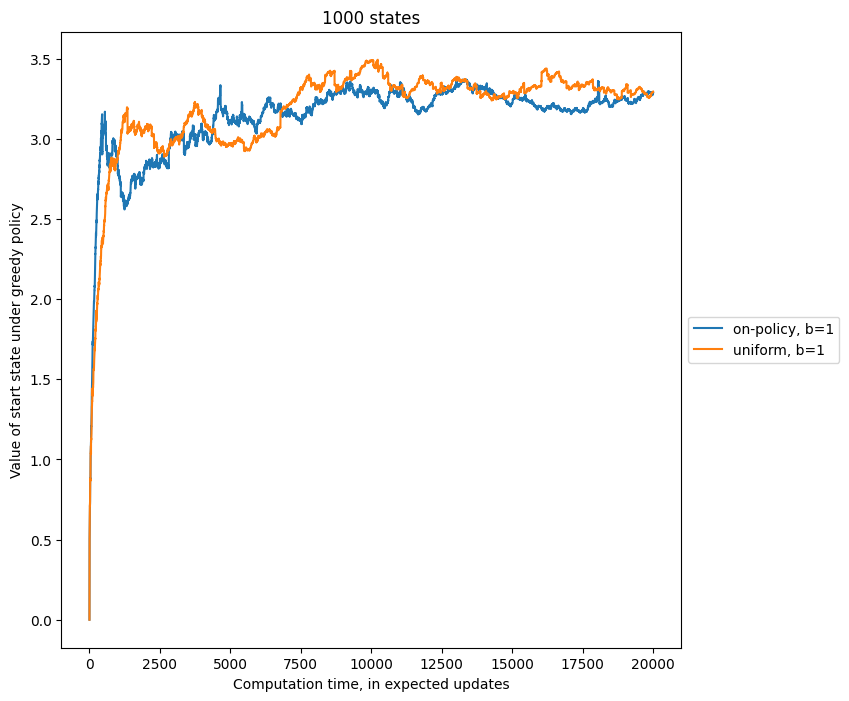

In [35]:
seed = 1
max_updates = 20000
n_states = 1000
tasks = 200
show_branching(
    title=f'{n_states} states',
    tasks=tasks,
    seed=seed,
    cases=[
        ('on-policy, b=1', lambda task_seed: test_case(n_states=n_states, plan_all=False, b=1, max_updates=max_updates, seed=task_seed)),
        # ('on-policy, b=3', lambda task_seed: test_case(n_states=n_states, plan_all=False, b=3, max_updates=max_updates, seed=task_seed)),
        # ('on-policy, b=10', lambda task_seed: test_case(n_states=n_states, plan_all=False, b=10, max_updates=max_updates, seed=task_seed)),

        ('uniform, b=1', lambda task_seed: test_case(n_states=n_states, plan_all=True, b=1, max_updates=max_updates, seed=task_seed)),
        # ('uniform, b=3', lambda task_seed: test_case(n_states=n_states, plan_all=True, b=3, max_updates=max_updates, seed=task_seed)),
        # ('uniform, b=10', lambda task_seed: test_case(n_states=n_states, plan_all=True, b=10, max_updates=max_updates, seed=task_seed)),
    ],
)

Last value of start state
seed 4813
[task: 1] on-policy, b=1: 3.5721070635417447
seed 18019
[task: 2] on-policy, b=1: 3.6133208847538336
seed 14591
[task: 3] on-policy, b=1: 4.732213870872599
seed 2178
[task: 4] on-policy, b=1: 3.2398319829165705
seed 11167
[task: 5] on-policy, b=1: 3.617892056794914
seed 18618
[task: 6] on-policy, b=1: 4.187758486723473
seed 10536
[task: 7] on-policy, b=1: 3.7301229333524026
seed 3556
[task: 8] on-policy, b=1: 2.6049356506826133
seed 2938
[task: 9] on-policy, b=1: 4.388200758616884
seed 6603
[task: 10] on-policy, b=1: 4.195473368282958
seed 18144
[task: 11] on-policy, b=1: 2.1537420773879563
seed 3069
[task: 12] on-policy, b=1: 4.973035310779546
seed 9334
[task: 13] on-policy, b=1: 2.3563884793504477
seed 13728
[task: 14] on-policy, b=1: 4.229033691123523
seed 8718
[task: 15] on-policy, b=1: 3.7224987280847306
seed 3027
[task: 16] on-policy, b=1: 4.1421755360184624
seed 3381
[task: 17] on-policy, b=1: 2.9065552680931783
seed 18746
[task: 18] on-policy

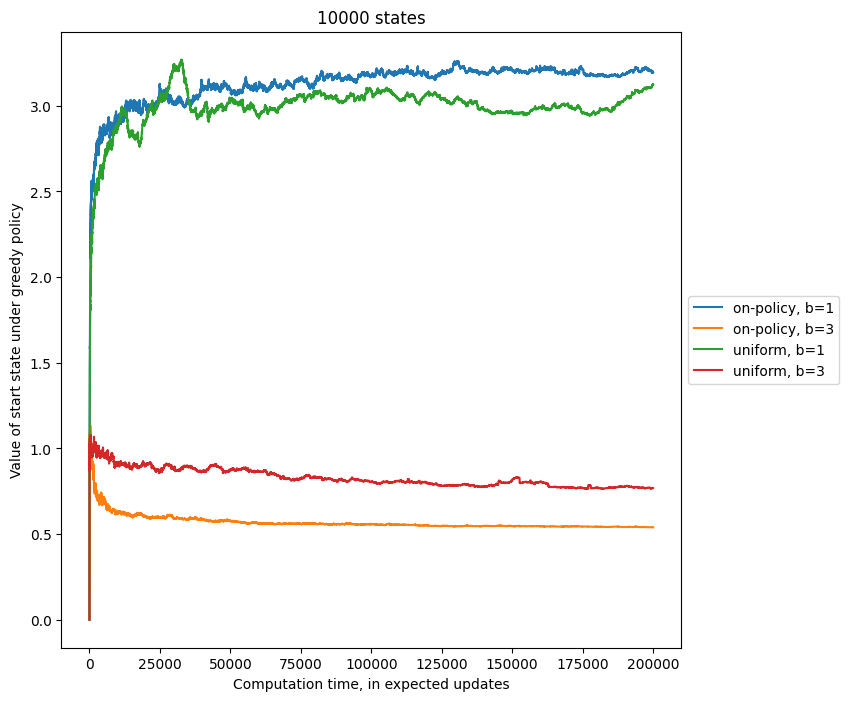

In [36]:
seed = 1
max_updates = 200000
n_states = 10000
tasks = 200
show_branching(
    title=f'{n_states} states',
    tasks=tasks,
    seed=seed,
    cases=[
        ('on-policy, b=1', lambda task_seed: test_case(n_states=n_states, plan_all=False, b=1, max_updates=max_updates, seed=task_seed)),
        ('on-policy, b=3', lambda task_seed: test_case(n_states=n_states, plan_all=False, b=3, max_updates=max_updates, seed=task_seed)),

        ('uniform, b=1', lambda task_seed: test_case(n_states=n_states, plan_all=True, b=1, max_updates=max_updates, seed=task_seed)),
        ('uniform, b=3', lambda task_seed: test_case(n_states=n_states, plan_all=True, b=3, max_updates=max_updates, seed=task_seed)),
    ],
)